In [19]:
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
import numpy as np


In [20]:
file_paths = glob.glob("/data/tillson/llm-project/SimPO/outputs/*/eval-new.json")

dataframes = []
for file_path in file_paths:
    print(file_path)
    parent_dir = os.path.basename(os.path.dirname(file_path))
    print(parent_dir)
    dir_parts = parent_dir.split("-")

    if len(dir_parts) == 5:
        ranking_type = dir_parts[-1]
        model = dir_parts[-2]
    elif len(dir_parts) == 4:
        ranking_type = "random"
        model = dir_parts[-1]
    else:
        ranking_type = "unknown"
        model = "unknown"

    df = pd.read_json(file_path, lines=True)
    df['parent_dir'] = parent_dir
    df['ranking_type'] = ranking_type
    df['model'] = model
    dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True)
df = df.drop_duplicates(["checkpoint_prop", "checkpoint"])


/data/tillson/llm-project/SimPO/outputs/mistral-7b-base-dpo-length/eval-new.json
mistral-7b-base-dpo-length
/data/tillson/llm-project/SimPO/outputs/mistral-7b-base-simpo-length/eval-new.json
mistral-7b-base-simpo-length
/data/tillson/llm-project/SimPO/outputs/mistral-7b-base-dpo-complexity/eval-new.json
mistral-7b-base-dpo-complexity
/data/tillson/llm-project/SimPO/outputs/mistral-7b-base-simpo-new/eval-new.json
mistral-7b-base-simpo-new
/data/tillson/llm-project/SimPO/outputs/mistral-7b-base-dpo/eval-new.json
mistral-7b-base-dpo
/data/tillson/llm-project/SimPO/outputs/mistral-7b-base-simpo-complexity/eval-new.json
mistral-7b-base-simpo-complexity


In [21]:
len(df)

58

In [22]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

# Assuming df is already defined with columns 'parent_dir', 'checkpoint_prop', 'eval_rewards/accuracies', and 'eval_runtime'

def log_utility(x, a, b, c):
    return a * np.log(b * x + c)

def linear_cost(x, d, e):
    return d * x + e

# Normalization function
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Assuming 'df' has these columns: 'parent_dir', 'checkpoint_prop', 'eval_rewards/accuracies', 'eval_runtime'
# Simulating the structure of the DataFrame for demonstration purposes
np.random.seed(42)

# Normalize columns
df['checkpoint_prop'] = normalize(df['checkpoint_prop'])
df['eval_rewards/accuracies'] = normalize(df['eval_rewards/accuracies'])
df['eval_runtime'] = normalize(df['eval_runtime'])

results = []

# Group data by parent directory
for parent_dir, group in df.groupby('parent_dir'):
    x = group['checkpoint_prop'].values
    y_utility = group['eval_rewards/accuracies'].values
    y_cost = np.cumsum(group['eval_runtime'].values)
    
    # Fit logarithmic utility function
    try:
        popt_utility, _ = curve_fit(log_utility, x, y_utility, maxfev=10000)
        y_pred_utility = log_utility(x, *popt_utility)
        mse_utility = mean_squared_error(y_utility, y_pred_utility)
    except RuntimeError:
        popt_utility = [np.nan, np.nan, np.nan]
        mse_utility = np.nan
    
    # Fit linear cost function
    try:
        popt_cost, _ = curve_fit(linear_cost, x, y_cost, maxfev=10000)
        y_pred_cost = linear_cost(x, *popt_cost)
        mse_cost = mean_squared_error(y_cost, y_pred_cost)
    except RuntimeError:
        popt_cost = [np.nan, np.nan]
        mse_cost = np.nan
    
    results.append({
        "parent_dir": parent_dir,
        "log_utility_params": popt_utility,
        "linear_cost_params": popt_cost,
        "mse_utility": mse_utility,
        "mse_cost": mse_cost
    })

# Create a DataFrame of the results
fit_results_df = pd.DataFrame(results)

fit_results_df

/tmp/ipykernel_1507766/1852509304.py:9: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x + c)
/tmp/ipykernel_1507766/1852509304.py:9: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x + c)


,parent_dir,log_utility_params,linear_cost_params,mse_utility,mse_cost
0,mistral-7b-base-dpo,"[nan, nan, nan]","[-1.3459903448362578, 2.916096114127023]",NaN,1.392020
1,mistral-7b-base-dpo-complexity,"[0.15864742265847773, 0.008693245116097143, 2....","[5.794793989690348, 0.392683065221561]",0.000060,0.062565
2,mistral-7b-base-dpo-length,"[338.3296249053761, -0.00024271637236042204, 1...","[2.9219592684031985, 0.11550645698437043]",0.000235,0.007423
3,mistral-7b-base-simpo-complexity,"[0.3276616962312897, 13.963369885381535, 1.507...","[3.105387619923482, 0.10464147403043172]",0.000370,0.006657
4,mistral-7b-base-simpo-length,"[0.11494205818539036, 31.5547498125268, 0.9482...","[2.3722515253353174, 0.771586013650099]",0.001205,0.026731
5,mistral-7b-base-simpo-new,"[0.4171802834305419, 11.205887209203498, 1.367...","[4.821414329032621, -0.4736521583141969]",0.001945,0.354497


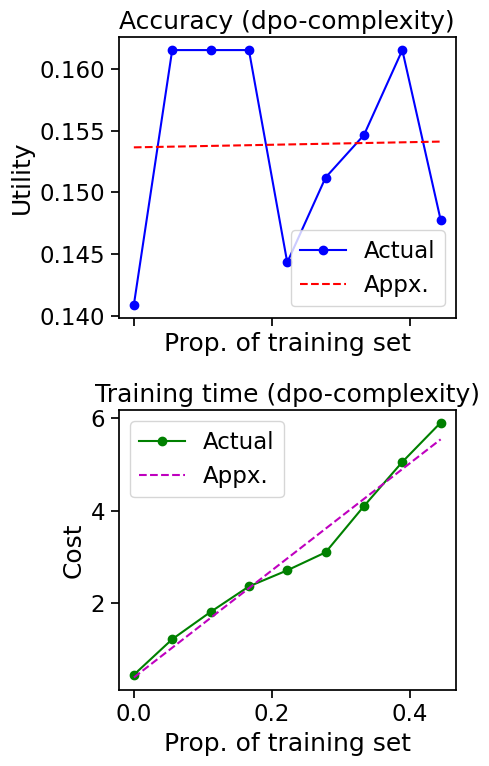

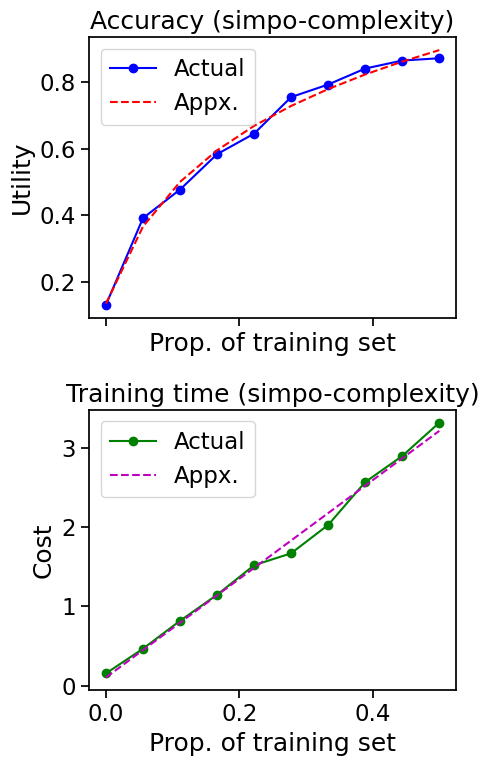

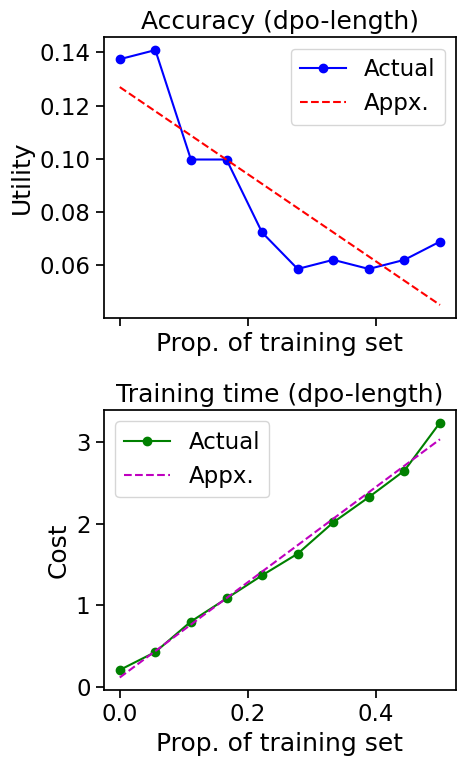

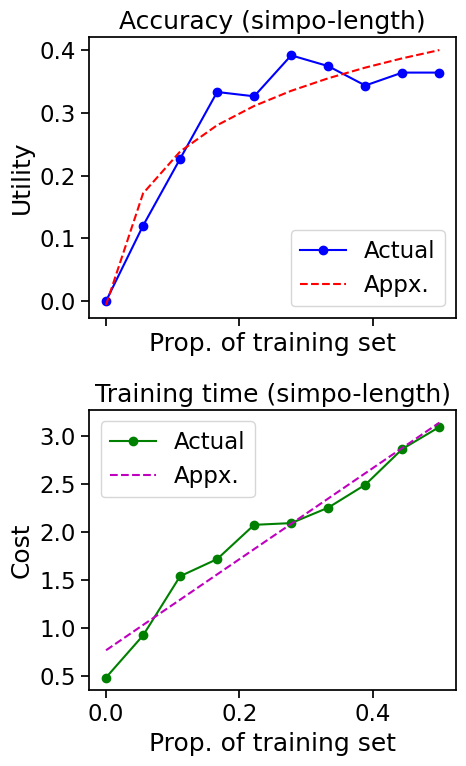

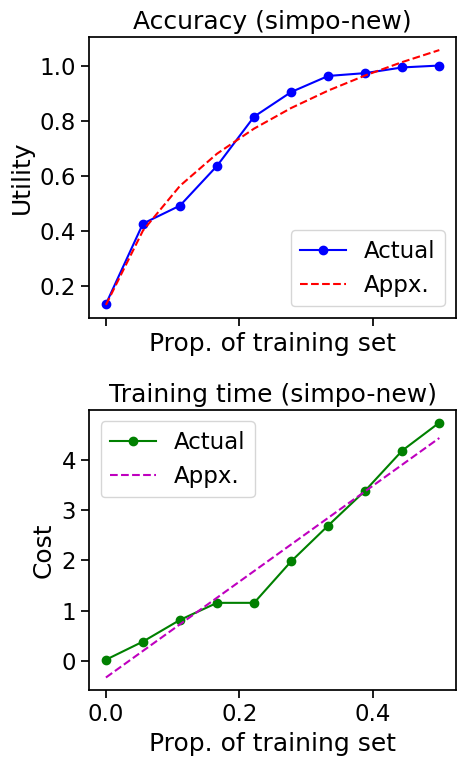

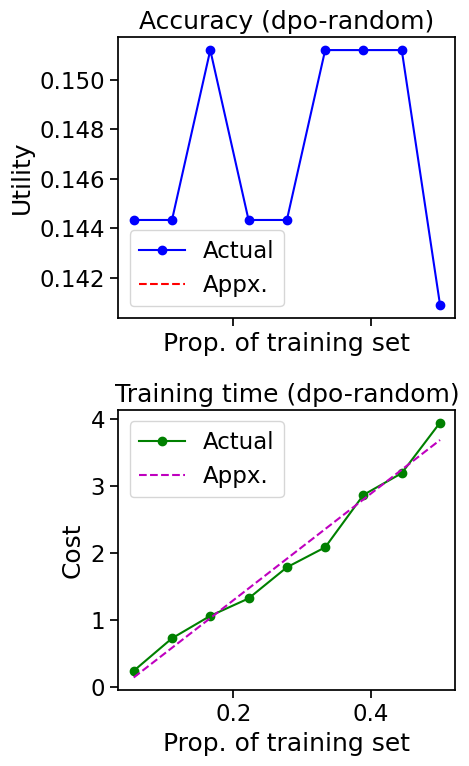

In [23]:
def log_utility(x, a, b, c):
    return a * np.log(b * x + c)

def linear_cost(x, d, e):
    return d * x + e

results = []


# Sort the data points by 'checkpoint_prop' within each group for consistent plotting
for (ranking_type, model), group in df.groupby(["ranking_type", "model"]):
    group = group.sort_values(by='checkpoint_prop').replace({"simpo": "SimPO", "dpo": "DPO"}).replace({"SimPO-new": "SimPO-random"})
    group["checkpoint_prop"] = group["checkpoint_prop"] / 2
    x = group['checkpoint_prop'].values
    y_utility = group['eval_rewards/accuracies'].values
    y_cost = np.cumsum(group['eval_runtime'].values)
    
    # Fit logarithmic utility function
    try:
        popt_utility, _ = curve_fit(log_utility, x, y_utility, maxfev=10000)
        y_pred_utility = log_utility(x, *popt_utility)
    except RuntimeError:
        y_pred_utility = np.full_like(y_utility, np.nan)
    
    # Fit linear cost function
    try:
        popt_cost, _ = curve_fit(linear_cost, x, y_cost, maxfev=10000)
        y_pred_cost = linear_cost(x, *popt_cost)
    except RuntimeError:
        y_pred_cost = np.full_like(y_cost, np.nan)
        
    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(5, 8), sharex=True)

    # Plot Utility
    axes[0].plot(x, y_utility, 'bo-', label='Actual')
    axes[0].plot(x, y_pred_utility, 'r--', label='Appx.')
    axes[0].set_title(f'Accuracy ({model}-{ranking_type})')
    axes[0].set_xlabel('Prop. of training set')
    axes[0].set_ylabel('Utility')
    axes[0].legend()

    # Plot Cost
    axes[1].plot(x, y_cost, 'go-', label='Actual')
    axes[1].plot(x, y_pred_cost, 'm--', label='Appx.')
    axes[1].set_title(f'Training time ({model}-{ranking_type})')
    axes[1].set_xlabel('Prop. of training set')
    axes[1].set_ylabel('Cost')
    axes[1].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


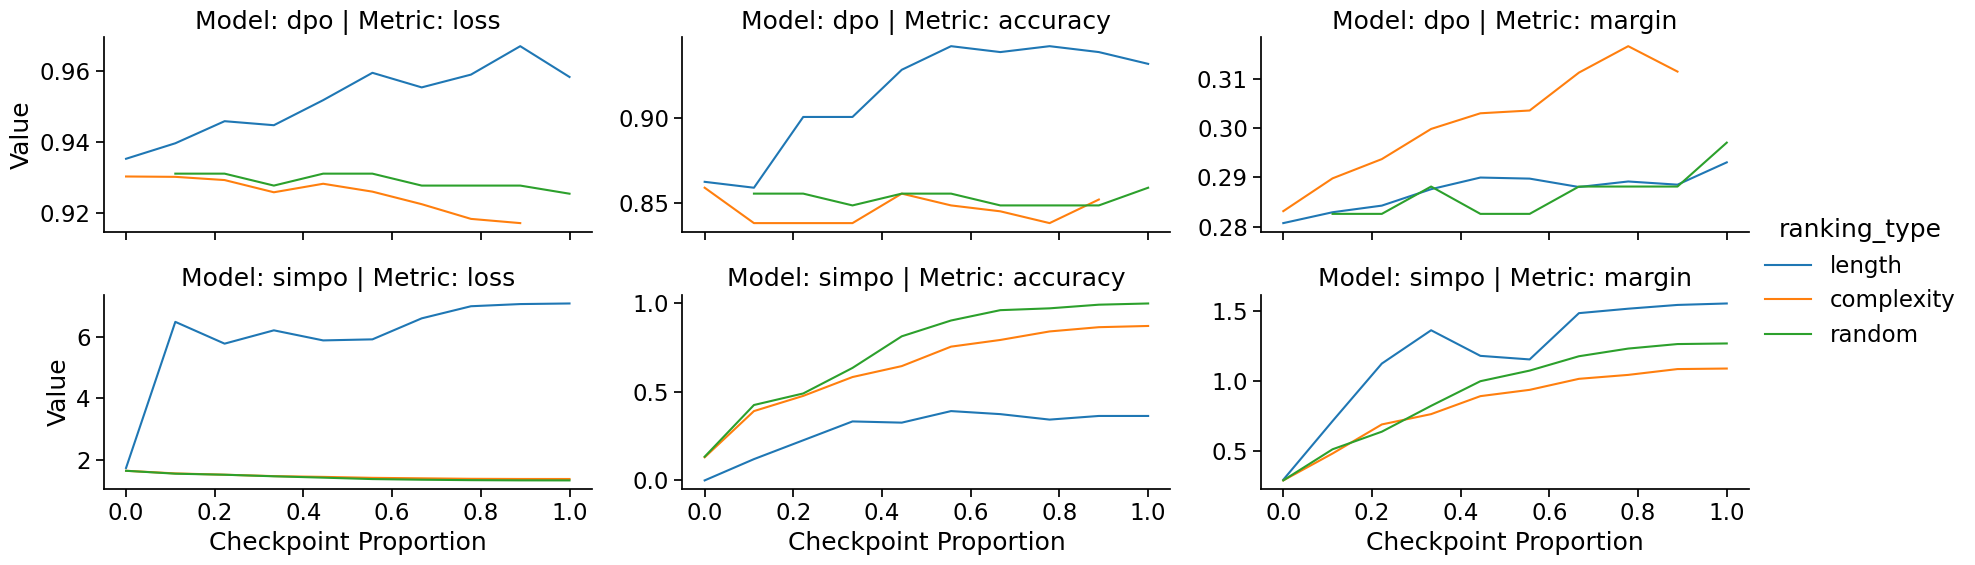

In [35]:
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt


# Step 3: Melt the dataframe for plotting
sns.set_context("notebook", font_scale=1.5)  # Adjust font_scale for overall scaling

melted_df = pd.melt(
    df,
    id_vars=['checkpoint_prop', 'ranking_type', 'model'],
    value_vars=['eval_loss', 'eval_rewards/accuracies', 'eval_rewards/margins'],
    var_name='metric',
    value_name='value'
).replace({
    "eval_loss": "loss",
    "eval_rewards/accuracies": "accuracy",
    "eval_rewards/margins": "margin"
}).replace({"new": "random"})
# melted_df.loc[(melted_df['model'] == 'DPO') & (melted_df['metric'] == 'accuracy'), 'value'] = 1 - melted_df.loc[(melted_df['model'] == 'DPO') & (melted_df['metric'] == 'accuracy'), 'value']

# Step 4: Create a facet plot with toggle for transposing rows and columns
transpose_plot = False  # Toggle this flag to transpose rows and columns

if transpose_plot:
    facet = sns.FacetGrid(
        melted_df, 
        col="model", 
        row="metric", 
        hue="ranking_type", 
        height=3, 
        aspect=2,
        sharey=False  # Disable shared y-axes for better scaling
    )
else:
    facet = sns.FacetGrid(
        melted_df, 
        col="metric", 
        row="model", 
        hue="ranking_type", 
        height=3, 
        aspect=2,
        sharey=False  # Disable shared y-axes for better scaling
    )

facet.map(sns.lineplot, "checkpoint_prop", "value").add_legend()
facet.set_axis_labels("Checkpoint Proportion", "Value")
facet.set_titles(row_template="Model: {row_name}", col_template="Metric: {col_name}")
plt.savefig("facet_plot.pdf")

In [32]:
melted_df

,checkpoint_prop,ranking_type,model,metric,value
0,0.000000,length,dpo,loss,0.935302
1,0.111111,length,dpo,loss,0.939669
2,0.222222,length,dpo,loss,0.945882
3,0.333333,length,dpo,loss,0.944750
4,0.444444,length,dpo,loss,0.951803
...,...,...,...,...,...
169,0.555556,complexity,simpo,margin,0.935985
170,0.666667,complexity,simpo,margin,1.014606
171,0.777778,complexity,simpo,margin,1.042671
172,0.888889,complexity,simpo,margin,1.084229


In [25]:
fit_results_df

,parent_dir,log_utility_params,linear_cost_params,mse_utility,mse_cost
0,mistral-7b-base-dpo,"[nan, nan, nan]","[-1.3459903448362578, 2.916096114127023]",NaN,1.392020
1,mistral-7b-base-dpo-complexity,"[0.15864742265847773, 0.008693245116097143, 2....","[5.794793989690348, 0.392683065221561]",0.000060,0.062565
2,mistral-7b-base-dpo-length,"[338.3296249053761, -0.00024271637236042204, 1...","[2.9219592684031985, 0.11550645698437043]",0.000235,0.007423
3,mistral-7b-base-simpo-complexity,"[0.3276616962312897, 13.963369885381535, 1.507...","[3.105387619923482, 0.10464147403043172]",0.000370,0.006657
4,mistral-7b-base-simpo-length,"[0.11494205818539036, 31.5547498125268, 0.9482...","[2.3722515253353174, 0.771586013650099]",0.001205,0.026731
5,mistral-7b-base-simpo-new,"[0.4171802834305419, 11.205887209203498, 1.367...","[4.821414329032621, -0.4736521583141969]",0.001945,0.354497


In [26]:
import sympy as sp

# Define symbols for optimization
x = sp.symbols('x', real=True, positive=True)
a, b, c, d, e, lambd = sp.symbols('a b c d e lambda')

# Define the utility and cost functions
utility_function = a * sp.log(b * x + c)
cost_function = lambd * (d * x + e)**2

# Define the objective function to maximize
objective_function = utility_function - cost_function

# Compute the derivative and solve for x
derivative = sp.diff(objective_function, x)
optimal_x = sp.solve(derivative, x)

# Add optimal x to the table
lambd_value = 0.5
results_with_optimal_x = []

# def f(x, a, b, c, d, e):



for index, row in fit_results_df.iterrows():
    a_val, b_val, c_val = row['log_utility_params']
    d_val, e_val = row['linear_cost_params']
    
    if not any(pd.isna([a_val, b_val, c_val, d_val, e_val])):
        # print(1)
        try:
            # print(a_val, b_val, c_val, d_val, e_val, lambd_value)
            x_opt = [sol.evalf(subs={a: a_val, b: b_val, c: c_val, d: d_val, e: e_val, lambd: lambd_value}) 
                     for sol in optimal_x]
            x_opt = max(x_opt)
        except Exception as e:
            # print(e)
            x_opt = float('nan')
    else:
        x_opt = float('nan')
    
    results_with_optimal_x.append({
        "model": row["parent_dir"],
        "ranking_type": row["parent_dir"],
        "log_utility_params": row["log_utility_params"],
        "linear_cost_params": row["linear_cost_params"],
        "mse_utility": row["mse_utility"],
        "mse_cost": row["mse_cost"],
        "optimal_x": x_opt
    })
    # break

# Create a DataFrame of the results with optimal x
fit_results_with_optimal_x_df = pd.DataFrame(results_with_optimal_x)

# Output the table to LaTeX
latex_output = fit_results_with_optimal_x_df[["model", "ranking_type", "optimal_x"]].to_latex(index=False)
print(latex_output)


\begin{tabular}{lll}
\toprule
model & ranking_type & optimal_x \\
\midrule
mistral-7b-base-dpo & mistral-7b-base-dpo & NaN \\
mistral-7b-base-dpo-complexity & mistral-7b-base-dpo-complexity & -0.0677492046347037 \\
mistral-7b-base-dpo-length & mistral-7b-base-dpo-length & 4121.59115340178 \\
mistral-7b-base-simpo-complexity & mistral-7b-base-simpo-complexity & 0.117205605740794 \\
mistral-7b-base-simpo-length & mistral-7b-base-simpo-length & 0.0277993846658628 \\
mistral-7b-base-simpo-new & mistral-7b-base-simpo-new & 0.161520962251477 \\
\bottomrule
\end{tabular}



In [27]:
fit_results_df

,parent_dir,log_utility_params,linear_cost_params,mse_utility,mse_cost
0,mistral-7b-base-dpo,"[nan, nan, nan]","[-1.3459903448362578, 2.916096114127023]",NaN,1.392020
1,mistral-7b-base-dpo-complexity,"[0.15864742265847773, 0.008693245116097143, 2....","[5.794793989690348, 0.392683065221561]",0.000060,0.062565
2,mistral-7b-base-dpo-length,"[338.3296249053761, -0.00024271637236042204, 1...","[2.9219592684031985, 0.11550645698437043]",0.000235,0.007423
3,mistral-7b-base-simpo-complexity,"[0.3276616962312897, 13.963369885381535, 1.507...","[3.105387619923482, 0.10464147403043172]",0.000370,0.006657
4,mistral-7b-base-simpo-length,"[0.11494205818539036, 31.5547498125268, 0.9482...","[2.3722515253353174, 0.771586013650099]",0.001205,0.026731
5,mistral-7b-base-simpo-new,"[0.4171802834305419, 11.205887209203498, 1.367...","[4.821414329032621, -0.4736521583141969]",0.001945,0.354497


In [28]:
df

,eval_loss,eval_model_preparation_time,eval_runtime,eval_samples_per_second,eval_steps_per_second,eval_rewards/chosen,eval_rewards/rejected,eval_rewards/accuracies,eval_rewards/margins,eval_logps/rejected,eval_logps/chosen,eval_logits/rejected,eval_logits/chosen,eval_samples,checkpoint_prop,checkpoint,parent_dir,ranking_type,model
0,0.935302,0.3979,0.207823,3.645,0.911,-2.049956,-2.330663,0.137457,0.280707,-1.165332,-1.024978,-2.643943,-2.703843,2000,0.000000,outputs/mistral-7b-base-dpo-length/checkpoint-50,mistral-7b-base-dpo-length,length,dpo
1,0.939669,0.3596,0.220289,3.645,0.911,-2.085249,-2.368168,0.140893,0.282919,-1.184084,-1.042624,-2.629514,-2.690805,2000,0.111111,outputs/mistral-7b-base-dpo-length/checkpoint-100,mistral-7b-base-dpo-length,length,dpo
2,0.945882,0.3836,0.373980,3.642,0.911,-2.120511,-2.404778,0.099657,0.284268,-1.202389,-1.060255,-2.627339,-2.691387,2000,0.222222,outputs/mistral-7b-base-dpo-length/checkpoint-150,mistral-7b-base-dpo-length,length,dpo
3,0.944750,0.3689,0.282828,3.644,0.911,-2.121878,-2.409487,0.099657,0.287609,-1.204744,-1.060939,-2.613259,-2.675151,2000,0.333333,outputs/mistral-7b-base-dpo-length/checkpoint-250,mistral-7b-base-dpo-length,length,dpo
4,0.951803,0.3706,0.283372,3.644,0.911,-2.158640,-2.448618,0.072165,0.289978,-1.224309,-1.079320,-2.592467,-2.655623,2000,0.444444,outputs/mistral-7b-base-dpo-length/checkpoint-300,mistral-7b-base-dpo-length,length,dpo
5,0.959506,0.3790,0.265593,3.644,0.911,-2.202229,-2.491990,0.058420,0.289760,-1.245995,-1.101115,-2.611217,-2.673654,2000,0.555556,outputs/mistral-7b-base-dpo-length/checkpoint-350,mistral-7b-base-dpo-length,length,dpo
6,0.955399,0.3496,0.383727,3.642,0.911,-2.171632,-2.459686,0.061856,0.288053,-1.229843,-1.085816,-2.605841,-2.668051,2000,0.666667,outputs/mistral-7b-base-dpo-length/checkpoint-450,mistral-7b-base-dpo-length,length,dpo
7,0.958997,0.3559,0.309851,3.643,0.911,-2.190013,-2.479191,0.058420,0.289178,-1.239596,-1.095007,-2.601730,-2.664921,2000,0.777778,outputs/mistral-7b-base-dpo-length/checkpoint-500,mistral-7b-base-dpo-length,length,dpo
8,0.967001,0.3470,0.325580,3.643,0.911,-2.223789,-2.512319,0.061856,0.288530,-1.256159,-1.111894,-2.616327,-2.678114,2000,0.888889,outputs/mistral-7b-base-dpo-length/checkpoint-550,mistral-7b-base-dpo-length,length,dpo
9,0.958328,0.3537,0.588580,3.639,0.910,-2.195874,-2.488943,0.068729,0.293069,-1.244472,-1.097937,-2.604089,-2.666754,2000,1.000000,outputs/mistral-7b-base-dpo-length/checkpoint-650,mistral-7b-base-dpo-length,length,dpo


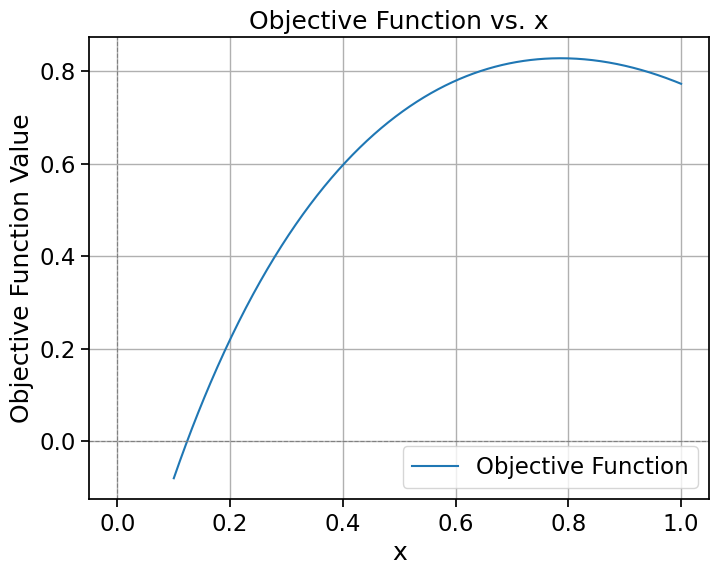

In [29]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np

# Define symbols for optimization
x = sp.symbols('x', real=True, positive=True)
a, b, c, d, e, lambd = sp.symbols('a b c d e lambda')

# Define the utility and cost functions
utility_function = a * sp.log(b * x + c)
cost_function = lambd * (d * x + e)**2

# Define the objective function to maximize
objective_function = utility_function - cost_function

# Lambdify the function for numerical evaluation
objective_func_num = sp.lambdify(
    (x, a, b, c, d, e, lambd),
    objective_function,
    modules="numpy"
)

# Parameters for visualization
params = {
    'a': 2, 'b': 3, 'c': 1,
    'd': 1, 'e': 1, 'lambd': 0.5
}

# Generate x values
x_values = np.linspace(0.1, 1, 500)  # Avoid division by zero or log(0)

# Evaluate the objective function for plotting
y_values = objective_func_num(
    x_values, 
    params['a'], params['b'], params['c'],
    params['d'], params['e'], params['lambd']
)

# Plot the objective function
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label="Objective Function")
plt.title("Objective Function vs. x")
plt.xlabel("x")
plt.ylabel("Objective Function Value")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.grid()
plt.legend()
plt.show()


In [30]:
optimal_x

[(lambda*(-b*e - c*d) - sqrt(lambda*(2*a*b**2 + b**2*e**2*lambda - 2*b*c*d*e*lambda + c**2*d**2*lambda)))/(2*b*d*lambda),
 (-lambda*(b*e + c*d) + sqrt(lambda*(2*a*b**2 + b**2*e**2*lambda - 2*b*c*d*e*lambda + c**2*d**2*lambda)))/(2*b*d*lambda)]

In [31]:
fit_results_df

,parent_dir,log_utility_params,linear_cost_params,mse_utility,mse_cost
0,mistral-7b-base-dpo,"[nan, nan, nan]","[-1.3459903448362578, 2.916096114127023]",NaN,1.392020
1,mistral-7b-base-dpo-complexity,"[0.15864742265847773, 0.008693245116097143, 2....","[5.794793989690348, 0.392683065221561]",0.000060,0.062565
2,mistral-7b-base-dpo-length,"[338.3296249053761, -0.00024271637236042204, 1...","[2.9219592684031985, 0.11550645698437043]",0.000235,0.007423
3,mistral-7b-base-simpo-complexity,"[0.3276616962312897, 13.963369885381535, 1.507...","[3.105387619923482, 0.10464147403043172]",0.000370,0.006657
4,mistral-7b-base-simpo-length,"[0.11494205818539036, 31.5547498125268, 0.9482...","[2.3722515253353174, 0.771586013650099]",0.001205,0.026731
5,mistral-7b-base-simpo-new,"[0.4171802834305419, 11.205887209203498, 1.367...","[4.821414329032621, -0.4736521583141969]",0.001945,0.354497
